In [616]:
import sys
sys.path.append("../")

from theory.units import *
import matplotlib.pyplot as plt
from simulation.astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm as cmaps
from simulation.estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u
from pylab import rcParams
import matplotlib as mpl
from simulation.subhalo_sim import SubhaloSample
from scipy.integrate import nquad, quad
from scipy.special import erf

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [617]:
sim = SubhaloSample()

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=30000, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.get_sh_sample()

Simulating 239953 subhalos between 7.0 and 10.0


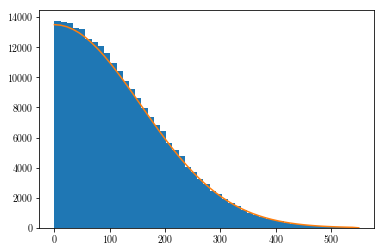

In [618]:
v_mag = np.linalg.norm(np.transpose([sim.coords_gc.v_x.value, sim.coords_gc.v_y.value,sim.coords_gc.v_z.value]), axis=1)

v_ary = np.linspace(0,550,50)
plt.hist(v_mag, bins=v_ary, density=False);
rho_v_SHM_scalar = sim.rho_v_SHM_scalar((v_ary)*Kmps)
plt.plot(v_ary, 15*900*rho_v_SHM_scalar)

In [619]:
pm = np.sqrt(sim.coords_galactic.pm_b ** 2 + sim.coords_galactic.pm_l_cosb ** 2)

In [620]:
v_t = (sim.coords_galactic.distance * pm).to(u.km / u.s, equivalencies=u.dimensionless_angles()).value

In [621]:
np.mean(v_t**2)*Kmps**2

5.789779157814031e-07

In [624]:
np.mean(v_t**4)*Kmps**4

5.914900709341262e-13

In [626]:
def rho_v_SHM_scalar(v, v0=220. * Kmps, vesc=544. * Kmps):
    """ Normalized truncated Maxwellian velocity distribution
    """
    return np.exp(-v ** 2 / ( v0) ** 2) * (v < vesc)

def rho_v_SHM(vvec, v0=220. * Kmps, vesc=544. * Kmps):
    """ Normalized truncated Maxwellian velocity distribution
    """
    Nesc = erf(vesc / v0) - 2 / np.sqrt(np.pi) * vesc / v0 * np.exp(-vesc ** 2 / v0 ** 2)
    v = np.linalg.norm(vvec)
    return 1 / (Nesc * np.pi ** 1.5 * v0 ** 3) * np.exp(-v ** 2 / v0 ** 2) * (v < vesc)

In [628]:
# v_ary = np.linspace(0,600,50)
# plt.hist(v_t, bins=v_ary, density=False);
# rho_v_ary = rho_v_SHM_scalar(v_ary*Kmps * np.sqrt(2))
# plt.plot(v_ary, 3*6.74799517e+03*rho_v_ary)

In [629]:
norm = np.array(quad(lambda v: 4*np.pi*(2 * v)**2*rho_v_SHM_scalar(2 * v), 0,550.*Kmps, epsabs=1.49e-14, epsrel=0, limit=500))[0]

In [630]:
vint = np.array(nquad(lambda v: (2 * v)**2*4*np.pi*(2 * v)**2*rho_v_SHM_scalar(2 * v), [[0,700.*Kmps]], opts={'epsabs':1.49e-30, 'epsrel':0, 'limit':500}))[0]
print(vint / norm)


7.873171459492965e-07


In [632]:
# v_sun = np.array([11., 232., 7.]) * Kmps
# vint = nquad(lambda v, theta, phi: (2 * v)**2*(2 * v)**2*np.sin(theta)*rho_v_SHM(2 * v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) + v_sun), [[0,600.*Kmps],[0,np.pi],[0,2*np.pi]])
# print(vint)